In [13]:
# FILE UPLOAD
from google.colab import files

uploaded = files.upload()

for filename in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(name=filename, length=len(uploaded[filename])))


Saving run2.txt to run2 (1).txt
Saving run3.txt to run3.txt
Saving run4.txt to run4.txt
User uploaded file "run2 (1).txt" with length 268840 bytes
User uploaded file "run3.txt" with length 266256 bytes
User uploaded file "run4.txt" with length 266161 bytes


**Part A:**
The CDFs are pictured below. The blue lines are for run1 and the orange lines are for run 2.

1. Similarity/Difference Within Same Run:
Similar Behavior: For run 1, all operations besides IMG_REGISTER have steep curves that rise quickly to 1, so they have all similar behavior in terms of response time. The same can be said for run 2.
Different Behavior: For both runs, IMG_REGISTER's CDF seems to differ in response time when compared to the other operations.

2. Least Predictable Operations: For run 1, IMG_ROT90CLKW and IMG_VERTEDGES have a relatively flatter CDF curve, indicating that response times can vary widely. For run 2, IMG_REGISTER, IMG_ROT90CLKW and IMG_VERTEDGES fit this description as well. Additionally, these three have longer tails in their CDF, further proving that their response times vary greatly.

3. Increase in Average Response Time Across Runs:
To determine how much the average response time increases across runs, we will look at the dashed lines for each operation between the blue and orange lines. Theh operations that have the greatest difference are IMG_ROT90CLKW and IMG_VERTEDGES.

4. Increase in 99% Tail Latency Across Runs:
The 99% tail latency is indicated by the dash-dotted lines. By looking at the position of these lines on the x-axis, it can be determined that the greatest difference across runs is with the operation IMG_VERTEDGES.

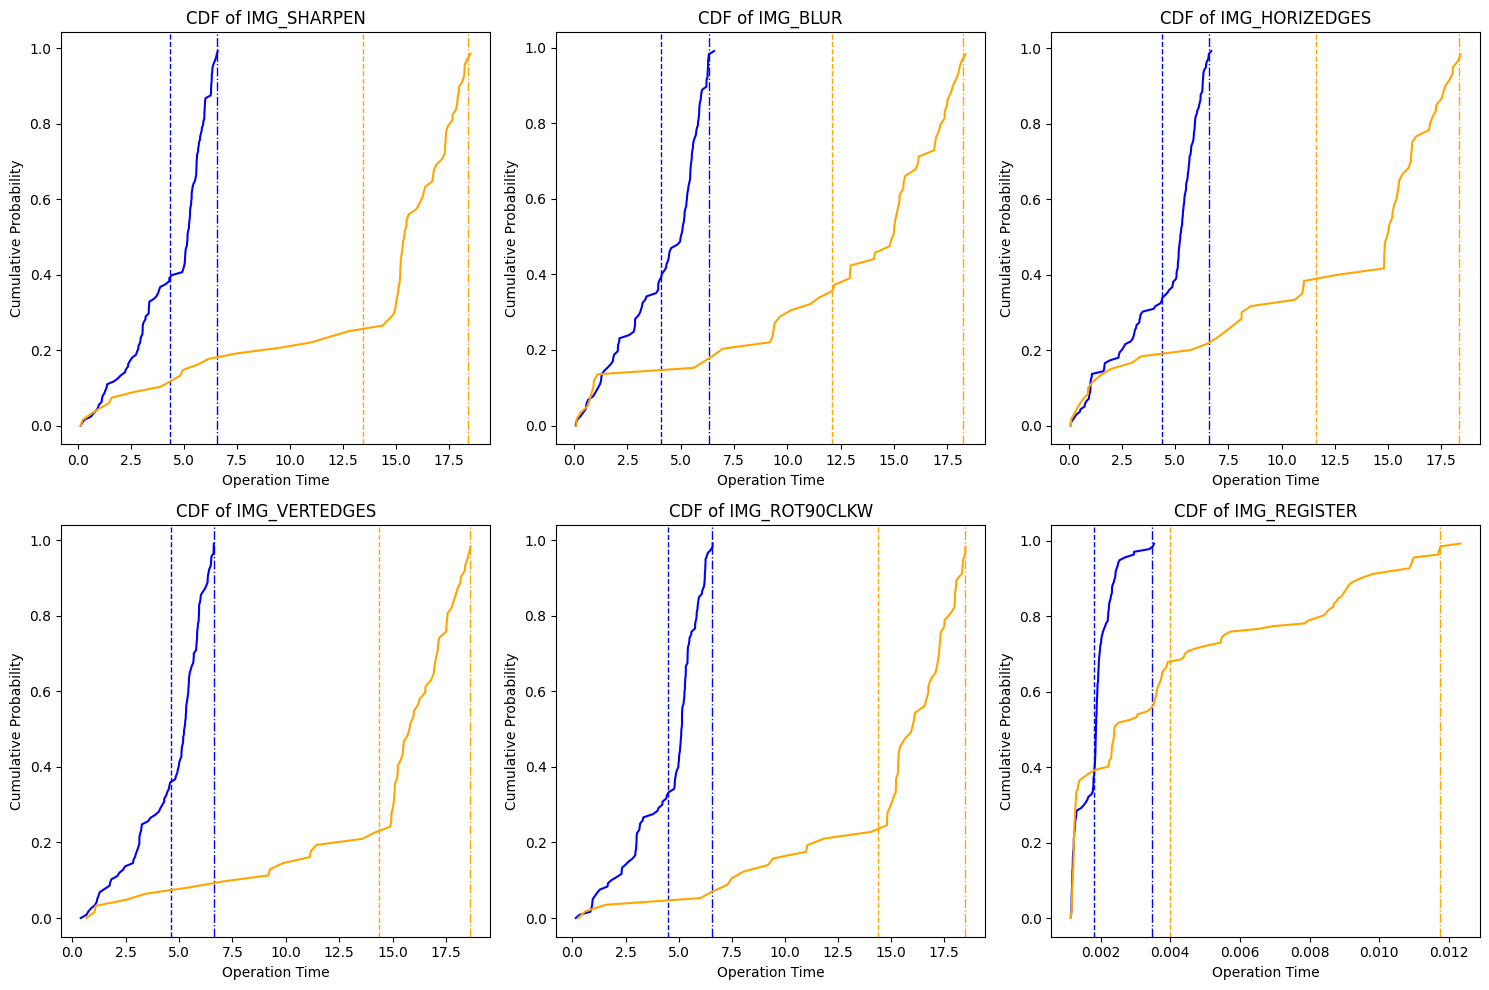

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import re

# Define operations to exclude IMG_RETRIEVE
operations = ['IMG_SHARPEN', 'IMG_BLUR', 'IMG_HORIZEDGES', 'IMG_VERTEDGES', 'IMG_ROT90CLKW', 'IMG_REGISTER']

def extract_operation_times(content, operation):
    pattern = re.compile(rf'T\d+ R\d+:\d+\.\d+,{operation},\d+,\d+,\d+,\d+\.\d+,\d+\.\d+,\d+\.\d+')
    times = []
    for line in content:
        if operation in line:
            match = pattern.search(line)
            if match:
                parts = line.split(',')
                start_time = float(parts[5])
                end_time = float(parts[7])
                times.append(end_time - start_time)
    return times

def plot_cdf(data, ax, operation, color):
    sorted_data = np.sort(data)
    yvals = np.arange(len(sorted_data)) / float(len(sorted_data))
    ax.plot(sorted_data, yvals, color=color, label=operation)
    ax.axvline(np.mean(data), color=color, linestyle='dashed', linewidth=1)
    ax.axvline(np.percentile(data, 99), color=color, linestyle='dashdot', linewidth=1)
    ax.set_title(f"CDF of {operation}")
    ax.set_xlabel("Operation Time")
    ax.set_ylabel("Cumulative Probability")

# Read the data from both runs
with open('run1.txt', 'r') as file:
    run1_content = file.readlines()

with open('run2.txt', 'r') as file:
    run2_content = file.readlines()

# Set up plot grid
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()

# Plot CDFs for each operation for both runs
for i, operation in enumerate(operations):
    # Extract times
    run1_times = extract_operation_times(run1_content, operation)
    run2_times = extract_operation_times(run2_content, operation)

    # Plot
    plot_cdf(run1_times, axes[i], f"{operation}", 'blue')
    plot_cdf(run2_times, axes[i], f"{operation}", 'orange')

plt.tight_layout()
plt.show()


**Part B:**

The averages are printed by the code below:

In [12]:
import re

# Exponential Weighted Moving Average (EWMA) calculation
def ewma(old, new, alpha=0.7):
    return alpha * new + (1 - alpha) * old

# Parse the server output and calculate EWMA for each operation
def parse_and_predict(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()

    # Define a pattern to extract relevant data
    # Assuming the operation name is right after the request timestamp
    pattern = re.compile(r'T\d+ R\d+:(\d+\.\d+),(\w+),\d+,\d+,\d+,\d+\.\d+,(\d+\.\d+),(\d+\.\d+)')

    operations_ewma = {}  # To store the EWMAs for each operation
    operations_errors = {}  # To store the prediction errors for each operation

    for line in lines:
        if line.startswith('X'):  # Skip rejected requests
            continue
        match = pattern.search(line)
        if match:
            sent_ts, operation, start_ts, compl_ts = match.groups()
            if operation == 'IMG_RETRIEVE':
                continue  # Skip IMG_RETRIEVE operation
            start_ts, compl_ts = map(float, [start_ts, compl_ts])
            job_length = compl_ts - start_ts

            # Initialize the EWMA with the first job length if it doesn't exist yet
            if operation not in operations_ewma:
                operations_ewma[operation] = job_length
                operations_errors[operation] = []
            else:
                # Calculate the misprediction error
                prediction_error = abs(operations_ewma[operation] - job_length)
                operations_errors[operation].append(prediction_error)
                # Update the EWMA for the next prediction
                operations_ewma[operation] = ewma(operations_ewma[operation], job_length)

    # Calculate the average prediction error for each operation
    average_errors = {op: sum(errors)/len(errors) if errors else float('nan')
                      for op, errors in operations_errors.items()}

    return average_errors, operations_ewma

# Calculate misprediction errors for RUN2
errors_run2, ewma_run2 = parse_and_predict('run2.txt')

# Calculate and print the average error for each operation
for op, error in errors_run2.items():
    print(f"Operation: {op}, Average Error: {error:.4f}")

# Print the final EWMA for each operation
for op, final_ewma in ewma_run2.items():
    print(f"Operation: {op}, Final EWMA: {final_ewma:.4f}")


Operation: IMG_REGISTER, Average Error: 0.0000
Operation: IMG_HORIZEDGES, Average Error: 0.1440
Operation: IMG_SHARPEN, Average Error: 0.1556
Operation: IMG_BLUR, Average Error: 0.0912
Operation: IMG_ROT90CLKW, Average Error: 0.0151
Operation: IMG_VERTEDGES, Average Error: 0.2252
Operation: IMG_REGISTER, Final EWMA: 0.0000
Operation: IMG_HORIZEDGES, Final EWMA: 0.0916
Operation: IMG_SHARPEN, Final EWMA: 0.2428
Operation: IMG_BLUR, Final EWMA: 0.2944
Operation: IMG_ROT90CLKW, Final EWMA: 0.0081
Operation: IMG_VERTEDGES, Final EWMA: 0.1300


**Part C:**
The CDFs for all three values (-O0, -O1, -O2) are all plotted below.

The -O flags supposedly control the level of optimization during the compilation of a program. Here's what I found about the meanings of each flag:

-O0: No optimization. Does the quickest compilation time and provides the most straightforward debugging experience because it makes no changes to your code.

-O1: Begins to optimize the compiled code. Attempts to reduce code size + execution time without performing any optimizations that take a considerable amount of compilation time.

-O2: Provides all supported optimizations that don't involve a "space-speed" tradeoff. The compiler adds more optimization that may increase execution speed but may also increase the size of the code.

Looking at the plot I generated:

The blue line (-O0) represents the least optimized code, so it's expected that would, on average, have the longest operation times and the highest tail latency.

The green line (-O1) represents a moderate level of optimization, so it's expected to perform better than -O0 but not as well as -O2.

The red line (-O2) represents a higher level of optimization, so it's expected to have the shortest operation times and the lowest tail latency.

By analyzing the plot, I think it's clear that the use of the three different flags definitely made a difference in the results that I obtained, but the results aren't exactly on par with what one would expect. By this, I mean that I would have expected the red line representing -O2 would have performed better than the -O0 blue line, but it did not. I think that the flags are likely not performing as expected because my machine is not strong enough :(. Earlier on during the EVAL I saw that I was experiencing a few more rejections than expected, and looking back I probably should have reduced the input as to obtain more useful data.

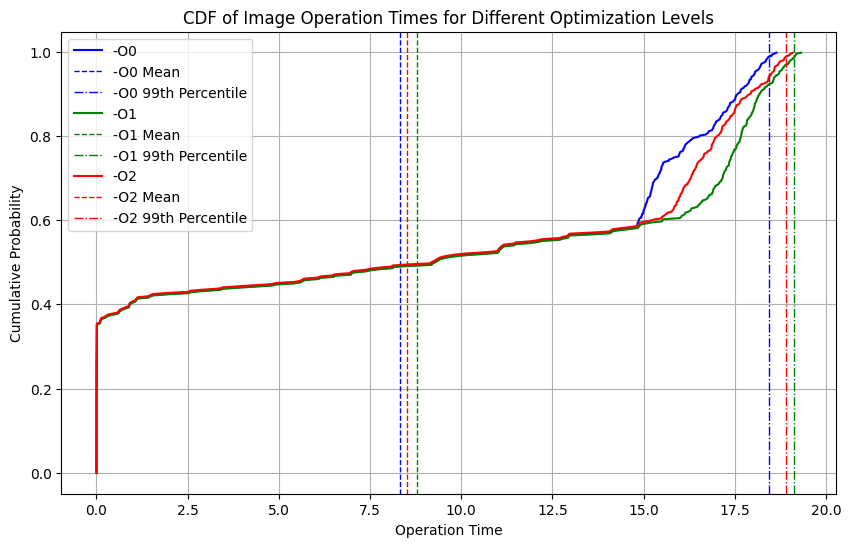

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import re

# Define the operation pattern
operation_pattern = re.compile(r'T\d+ R\d+:\d+\.\d+,(IMG_[A-Z]+),\d+,\d+,\d+,\d+\.\d+,\d+\.\d+,\d+\.\d+')

def extract_operation_times(content):
    times = []
    for line in content:
        if 'IMG_RETRIEVE' in line:  # Skip IMG_RETRIEVE operations
            continue
        match = operation_pattern.search(line)
        if match:
            parts = line.split(',')
            start_time = float(parts[-3])
            end_time = float(parts[-1])
            times.append(end_time - start_time)
    return times

def plot_cdf(data, label, color):
    sorted_data = np.sort(data)
    yvals = np.arange(len(sorted_data)) / float(len(sorted_data))
    plt.plot(sorted_data, yvals, color=color, label=label)
    plt.axvline(np.mean(data), color=color, linestyle='dashed', linewidth=1, label=f"{label} Mean")
    plt.axvline(np.percentile(data, 99), color=color, linestyle='dashdot', linewidth=1, label=f"{label} 99th Percentile")

# Read the data from all runs
with open('run2.txt', 'r') as file:
    run2_content = file.readlines()
with open('run3.txt', 'r') as file:
    run3_content = file.readlines()
with open('run4.txt', 'r') as file:
    run4_content = file.readlines()

# Extract times for each run
run2_times = extract_operation_times(run2_content)
run3_times = extract_operation_times(run3_content)
run4_times = extract_operation_times(run4_content)

# Set up the figure for plotting
plt.figure(figsize=(10, 6))

# Plot CDFs for each optimization level
plot_cdf(run2_times, '-O0', 'blue')
plot_cdf(run3_times, '-O1', 'green')
plot_cdf(run4_times, '-O2', 'red')

# Finalize plot
plt.title("CDF of Image Operation Times for Different Optimization Levels")
plt.xlabel("Operation Time")
plt.ylabel("Cumulative Probability")
plt.legend()
plt.grid(True)
plt.show()
